# Road Segmentation using U0NET and PyTorch
This notebook demonstrates a complete workflow for a road segmentation task using a U-Net-based model. We will be using a subset of the Massachusetts Roads Dataset.

The primary goal is to train a model that can accurately identify and segment roads from high-resolution aerial images.

## Project Workflow
Setup: Import necessary libraries and configure the environment.
Configuration: Define key parameters and hyperparameters for the project.
Data Loading and Exploration: Load the dataset metadata and visualize sample images and their corresponding masks.
Data Augmentation: Define image augmentation pipelines for training and validation sets to improve model robustness.
Custom Dataset and DataLoaders: Create a custom PyTorch Dataset and prepare DataLoaders for batching.
Model Architecture: Define the segmentation model using the segmentation-models-pytorch library.
Training: Implement the training and validation loops and train the model.
Inference and Visualization: Perform inference on a sample image from the validation set and visualize the results.

### Setup
First, let's install the required libraries. It's recommended to do this in your terminal using a requirements.txt file for better environment management.


In [1]:
# It is recommended to run these installations in your terminal
# pip install segmentation-models-pytorch
# pip install -U git+https://github.com/albumentations-team/albumentations
# pip install --upgrade opencv-contrib-python
# pip install pandas scikit-learn matplotlib tqdm

Now, we import all the necessary libraries for the project.

In [ ]:
# %% [markdown]
# # Road Segmentation from Aerial Imagery
# ---
# ### 1. Imports and Setup
# 
# This section consolidates all necessary library imports and clones the dataset if it's not already present.

# %%
# --- Core Libraries ---
import os
import sys
import time
import json

# --- Data Handling and Numerical Operations ---
import numpy as np
import pandas as pd
import cv2 # OpenCV

# --- Machine Learning and Deep Learning (PyTorch) ---
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# --- Data Preprocessing and Evaluation ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# --- Image Augmentation ---
import albumentations as A

# --- Visualization ---
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Custom Helper Functions ---
# Uncomment the following lines if the repository is not in the current directory
# !git clone https://github.com/parth1620/Road_seg_dataset.git
# sys.path.append('./Road_seg_dataset')
from Road_seg_dataset import helper


# %% [markdown]
# ### 2. Environment Configuration
# 
# We'll check for the availability of a GPU (CUDA or Apple's MPS) and set the device accordingly. If no GPU is found, it will default to the CPU.

/opt/anaconda3/envs/visualization/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Environment Configuration
We'll check for the availability of a GPU and set the device accordingly. This code is configured for CUDA, but also includes a check for Apple's Metal Performance Shaders (MPS).

In [3]:
# %%
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple's MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple's MPS


# Setup Configurations

In [5]:
# %%
CSV_FILE = './Road_seg_dataset/train.csv'
DATA_DIR = './Road_seg_dataset/'

EPOCHS = 15
LEARNING_RATE = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

# Model configuration using a pre-trained EfficientNet-B0 encoder
ENCODER = 'timm-efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'

### Data Loading and Exploration
We'll start by loading the train.csv file, which contains the file paths for the images and their corresponding masks.

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


Image Path: ./Road_seg_dataset/images/20428975_15.png
Mask Path:  ./Road_seg_dataset/masks/20428975_15.png


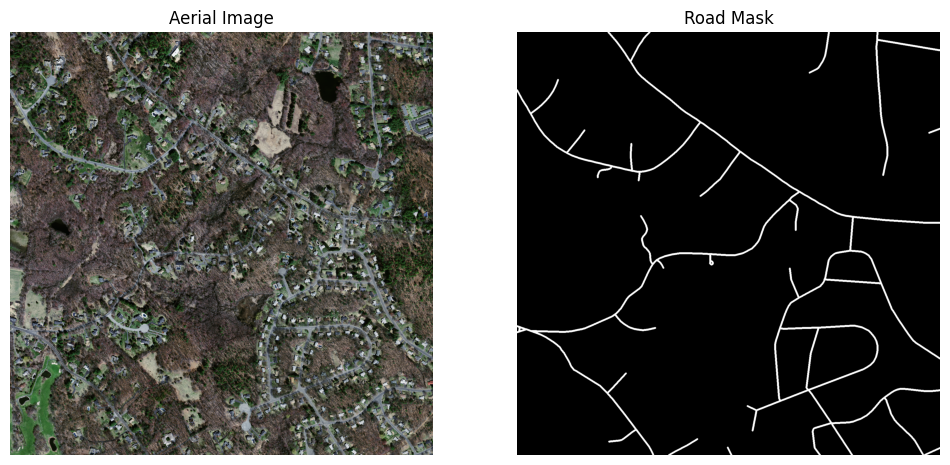

In [7]:
# %%
# Select a random index to display
idx = 20 
row = df.iloc[idx]

# Construct full paths
image_path = os.path.join(DATA_DIR, row.images)
mask_path = os.path.join(DATA_DIR, row.masks)

print(f"Image Path: {image_path}")
print(f"Mask Path:  {mask_path}")

# Read and process the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the mask and normalize it to a [0, 1] scale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

# Plotting the image and mask
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title('Aerial Image')
ax1.imshow(image)
ax1.axis('off')

ax2.set_title('Road Mask')
ax2.imshow(mask, cmap='gray')
ax2.axis('off')

plt.show()

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
len(train_df), len(valid_df)

(159, 40)

# Augmentation Functions

In [10]:
# %%
def get_train_augs():
    """Defines the augmentation pipeline for the training set."""
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

def get_valid_augs():
    """Defines the augmentation pipeline for the validation set."""
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ])

### Custom Dataset and DataLoaders
We create a custom RoadSegmentationDataset class that inherits from torch.utils.data.Dataset. This class will handle loading, augmenting, and formatting the data for our model.

In [11]:
# %%
class RoadSegmentationDataset(Dataset):
    def __init__(self, dataframe, augmentations):
        self.dataframe = dataframe
        self.augmentation = augmentations

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(DATA_DIR, row.images)
        mask_path = os.path.join(DATA_DIR, row.masks)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # HWC format

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # HW format
        mask = np.expand_dims(mask, axis=-1) # Add channel dim -> HWC

        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Transpose to CHW format required by PyTorch and normalize
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        
        image = torch.tensor(image) / 255.0
        mask = torch.round(torch.tensor(mask) / 255.0)

        return image, mask

In [12]:
trainset = RoadSegmentationDataset(train_df, get_train_augs())
validset = RoadSegmentationDataset(valid_df, get_valid_augs())

In [13]:
print(f'Size of training set: {len(trainset)}')
print(f'Size of validation set: {len(validset)}')

Size of training set: 159
Size of validation set: 40


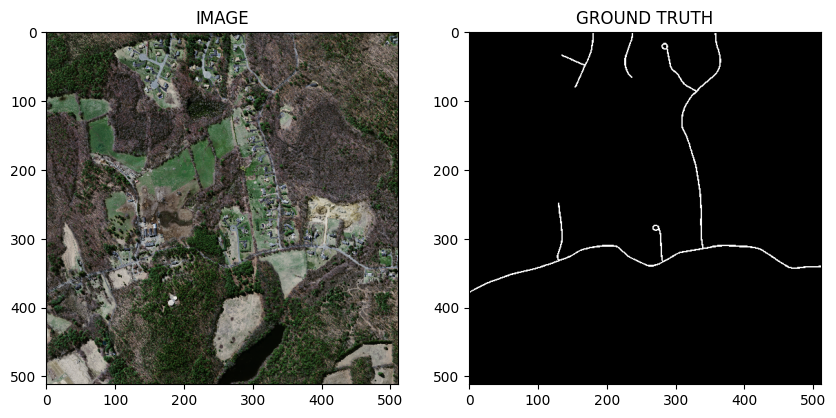

In [14]:
idx = 3
image, mask = trainset[idx]
helper.show_image(image, mask)

### Creating DataLoaders
DataLoaders are used to batch and shuffle the data, which is essential for efficient model training.

In [15]:
# %%
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total no. of batches in trainloader: {len(trainloader)}')
print(f'Total no. of batches in validloader: {len(validloader)}')

# Let's check the shape of one batch
for images, masks in trainloader:
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Shape of one batch of masks: {masks.shape}")
    break

Total no. of batches in trainloader: 20
Total no. of batches in validloader: 5
Shape of one batch of images: torch.Size([8, 3, 512, 512])
Shape of one batch of masks: torch.Size([8, 1, 512, 512])


### Load Dataset into Batches
Now, let's create instances of our dataset and visualize an augmented sample.

In [16]:
# trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
# validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [17]:
# print(f'Total no. of batches in trainloader : {len(trainloader)}')
# print(f'Total no. of batches in validloader : {len(validloader)}')

In [18]:
# for images, masks in trainloader:
#     print(f"One batch image shape: {images.shape}")
#     print(f"One batch mask shape: {mask.shape}")
#     break;

# Create Segmentation Model

segmentation_models_pytorch documentation: https://smp.readthedocs.io/en/latest/

In [19]:
# %%
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None  # We will apply sigmoid manually
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)

        if masks is not None:
            # Calculate loss if masks are provided
            loss = DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss
        
        return logits

model = SegmentationModel()
model.to(device)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): S

### Training the Model
We'll define two functions: one for the training step (train_fn) and one for the validation step (eval_fn).

In [20]:
# %%
def train_fn(data_loader, model, optimizer):
    """Function for a single training epoch."""
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        _, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    """Function for a single validation epoch."""
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)
            _, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader)

In [21]:
# def eval_fn(data_loader, model):
#     model.eval() # Set model to training mode, turn on dropout and batch normalization
#     total_loss = 0

#     with torch.no_grad():

#         for images, masks in tqdm(data_loader):

#             images = images.to(device)
#             masks = masks.to(device)
#             logits, loss = model(images, masks)
#             total_loss += loss.item()

#     return total_loss / len(data_loader)

### Train Model
Now we can start the training loop. We'll save the model with the best validation loss.

In [22]:
# %%
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        print("MODEL SAVED!")
        best_valid_loss = valid_loss
        
    print(f"Epoch {i+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


MODEL SAVED!
Epoch 1/15, Train Loss: 1.4501, Valid Loss: 1.2111


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


MODEL SAVED!
Epoch 2/15, Train Loss: 0.8900, Valid Loss: 0.8929


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


MODEL SAVED!
Epoch 3/15, Train Loss: 0.7534, Valid Loss: 0.8569


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


MODEL SAVED!
Epoch 4/15, Train Loss: 0.6970, Valid Loss: 0.7709


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


MODEL SAVED!
Epoch 5/15, Train Loss: 0.6898, Valid Loss: 0.7207


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 6/15, Train Loss: 0.6648, Valid Loss: 0.7346


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


MODEL SAVED!
Epoch 7/15, Train Loss: 0.6655, Valid Loss: 0.6748


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 8/15, Train Loss: 0.6357, Valid Loss: 0.6772


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 9/15, Train Loss: 0.6323, Valid Loss: 0.6789


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 10/15, Train Loss: 0.6316, Valid Loss: 0.6769


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


MODEL SAVED!
Epoch 11/15, Train Loss: 0.6206, Valid Loss: 0.6678


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 12/15, Train Loss: 0.6232, Valid Loss: 0.6697


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


MODEL SAVED!
Epoch 13/15, Train Loss: 0.6131, Valid Loss: 0.6516


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 14/15, Train Loss: 0.6064, Valid Loss: 0.6553


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

MODEL SAVED!
Epoch 15/15, Train Loss: 0.6000, Valid Loss: 0.6350


In [23]:
# best_loss = np.inf

# for i in range(EPOCHS):
#     train_loss = train_fn(trainloader, model, optimizer)
#     valid_loss = eval_fn(validloader, model)
    
#     if valid_loss < best_loss:
#         torch.save(model.state_dict(), 'best_model.pth')
#         print("SAVED_MODEL")
#         best_loss = valid_loss
#     print(f"Epoch {i + 1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}")

# inference

In [24]:
idx = 30

model.load_state_dict(torch.load('best_model.pth'))
image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0)) # (c, h, w) -> (b, c, h, w )

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

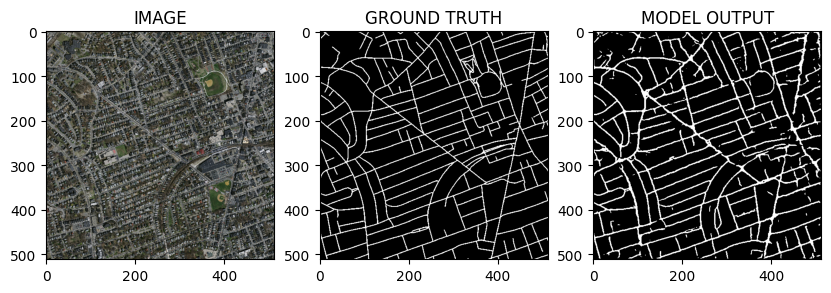

In [25]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))